# Automated Object Detection using YOLOv3.
This assignment is a modified version of source https://colab.research.google.com/github/zzh8829/yolov3-tf2/blob/master/colab_gpu.ipynb

You will learn about object detection using the very powerful YOLO model. Many of the ideas in this notebook are described in the two YOLO papers: Redmon et al., 2016 and Redmon and Farhadi, 2016.

Additionally, you will learn how to use a pre-trained model and fine tune it on new data.

## Begin by connecting colab to your local Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Create a Folder named 'YOLOv3' in your Google Drive. 
## This is the folder where all code and data will be collected.

In [3]:
import os
#os.chdir('/content/drive/MyDrive/data/YOLOv3')
os.chdir('/content/drive/MyDrive/YOLOv3')

### 1. Now lets install all requirements for the code base! 
This can take sometime!

In [ ]:
#!git clone https://github.com/zzh8829/yolov3-tf2

In [4]:
%cd yolov3-tf2/

/content/drive/MyDrive/YOLOv3/yolov3-tf2


In [5]:
current_path = os.getcwd()

In [ ]:
#!pip install -r requirements-gpu.txt

#### 2.  Check Tensorflow2 version

In [6]:
#Ensure you are located inside directory yolov3-tf2/. If not use the command 
#%cd yolov3-tf2
!ls

checkpoints	 data		  logs			setup.py
colab_gpu.ipynb  detect.py	  output.jpg		tools
conda-cpu.yml	 detect_video.py  README.md		train.py
conda-gpu.yml	 docs		  requirements-gpu.txt	yolov3_tf2
convert.py	 LICENSE	  requirements.txt	yolov3_tf2.egg-info


In [7]:
import tensorflow as tf
tf.__version__

'2.5.0'

### Download the test_images.zip, unzip them and manually move the images to './data/' folder. You will be required to run all experiments on these test images. You may have to rerun the notebook up to this point to refresh the data folders.

#### 3.  Now we retrieve a Pretrained model weights.
To learn more about DarkNet and its pretrained models refer to: https://towardsdatascience.com/custom-object-detection-using-darknet-9779170faca2

In [8]:
#!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!python convert.py

2021-07-04 16:16:12.334184: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-04 16:16:14.411929: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-04 16:16:14.476298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-04 16:16:14.476936: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-07-04 16:16:14.476981: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-04 16:16:14.619919: I tensorflow/stream_executor/platform/default

### 4 - Problem Statement

If you are building an objector for a self-driving car use case, a critical component of this project, is a specific object detector, i.e cars only or pedestrians only etc. To collect data, you've mounted a camera to the hood (meaning the front) of the car, which takes pictures of the road ahead every few seconds while you drive around. 

<center>
<video width="400" height="200" src="https://www.dropbox.com/s/804jv98ez3dllqd/road_video_compressed2.mp4?raw=1" type="video/mp4" controls>
</video>
</center>

<caption><center> Pictures taken from a car-mounted camera while driving around Silicon Valley. <br> We thank [drive.ai](htps://www.drive.ai/) for providing this dataset.
</center></caption>

You've gathered all these images into a folder and have labelled them by drawing bounding boxes around every car you found. Here's an example of what your bounding boxes look like.

<img src="https://www.dropbox.com/s/ljv8l2s15eizrlg/box_label.png?raw=1" style="width:500px;height:250;">
<caption><center> <u> <b>Figure 1</u>:</b> <b>Definition of a box</b> </center></caption>

If you have 80 classes that you want the object detector to recognize, you can represent the class label $c$ either as an integer from 1 to 80, or as an 80-dimensional vector (with 80 numbers) one component of which is 1 and the rest of which are 0. The video lectures had used the latter representation; in this notebook, we will use both representations, depending on which is more convenient for a particular step.  

In this exercise, you will learn how "You Only Look Once" (YOLOv3) performs object detection, and then apply it to object detection. YOLO models are training cost intensive, so we will begin with pre-trained weights and then fine tune the training process for a particular object class only!

"You Only Look Once" (YOLO) is a popular algorithm because it achieves high accuracy while also being able to run in real-time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

### 5.1 - Model details

#### Inputs and outputs
- The **input** is a batch of images, and each image has the shape (m, 608, 608, 3)
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$ as explained above. If you expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers. 

#### Anchor Boxes
* Anchor boxes are chosen by exploring the training data to choose reasonable height/width ratios that represent the different classes.  For this assignment, 5 anchor boxes were chosen for you (to cover the 80 classes), and stored in the file './model_data/yolo_anchors.txt'
* The dimension for anchor boxes is the second to last dimension in the encoding: $(m, n_H,n_W,anchors,classes)$.
* The YOLO architecture is: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).  


#### Encoding
Let's look in greater detail at what this encoding represents. 

<img src="https://www.dropbox.com/s/bpzqt82newudmvk/architecture.png?raw=1" style="width:700px;height:400;">
<caption><center> <u> <b>Figure 2</b> </u>: <b>Encoding architecture for YOLO</b> <br> </center></caption>

If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

Since we are using 5 anchor boxes, each of the 19 x19 cells thus encodes information about 5 boxes. Anchor boxes are defined only by their width and height.

For simplicity, we will flatten the last two last dimensions of the shape (19, 19, 5, 85) encoding. So the output of the Deep CNN is (19, 19, 425).

<img src="https://www.dropbox.com/s/3rhn01o6ud2dv89/flatten.png?raw=1" style="width:700px;height:400;">
<caption><center> <u> <b>Figure 3</b> </u>: <b>Flattening the last two last dimensions</b><br> </center></caption>

#### 5.2 Class score

Now, for each box (of each cell) we will compute the following element-wise product and extract a probability that the box contains a certain class.  
The class score is $score_{c,i} = p_{c} \times c_{i}$: the probability that there is an object $p_{c}$ times the probability that the object is a certain class $c_{i}$.

<img src="https://www.dropbox.com/s/04y7n9h1w38mkmd/probability_extraction.png?raw=1" style="width:700px;height:400;">
<caption><center> <u> <b>Figure 4</b> </u>: <b>Find the class detected by each box</b><br> </center></caption>

##### Example of figure 4
* In figure 4, let's say for box 1 (cell 1), the probability that an object exists is $p_{1}=0.60$.  So there's a 60% chance that an object exists in box 1 (cell 1).  
* The probability that the object is the class "category 3 (a car)" is $c_{3}=0.73$.  
* The score for box 1 and for category "3" is $score_{1,3}=0.60 \times 0.73 = 0.44$.  
* Let's say we calculate the score for all 80 classes in box 1, and find that the score for the car class (class 3) is the maximum.  So we'll assign the score 0.44 and class "3" to this box "1".

#### 5.3 Visualizing classes
Here's one way to visualize what YOLO is predicting on an image:
- For each of the 19x19 grid cells, find the maximum of the probability scores (taking a max across the 80 classes, one maximum for each of the 5 anchor boxes).
- Color that grid cell according to what object that grid cell considers the most likely.

Doing this results in this picture: 

<img src="https://www.dropbox.com/s/9r6cbdtsa947i6x/proba_map.png?raw=1" style="width:300px;height:300;">
<caption><center> <u> <b>Figure 5</b> </u>: Each one of the 19x19 grid cells is colored according to which class has the largest predicted probability in that cell.<br> </center></caption>

Note that this visualization isn't a core part of the YOLO algorithm itself for making predictions; it's just a nice way of visualizing an intermediate result of the algorithm. 


#### 5.4 Visualizing bounding boxes
Another way to visualize YOLO's output is to plot the bounding boxes that it outputs. Doing that results in a visualization like this:  

<img src="https://www.dropbox.com/s/x8abfjj9hgwu638/anchor_map.png?raw=1" style="width:200px;height:200;">
<caption><center> <u> <b>Figure 6</b> </u>: Each cell gives you 5 boxes. In total, the model predicts: 19x19x5 = 1805 boxes just by looking once at the image (one forward pass through the network)! Different colors denote different classes. <br> </center></caption>

#### Non-Max suppression
In the figure above, we plotted only boxes for which the model had assigned a high probability, but this is still too many boxes. You'd like to reduce the algorithm's output to a much smaller number of detected objects.  

To do so, you'll use <b>non-max suppression</b>. Specifically, you'll carry out these steps: 
- Get rid of boxes with a low score (meaning, the box is not very confident about detecting a class; either due to the low probability of any object, or low probability of this particular class).
- Select only one box when several boxes overlap with each other and detect the same object.

Now that we have a better understanding of the undelying model, lets apply the pre-trained detector on sample images.


### 6. Load the libraries, model weights and images

In [9]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')

#Sample image is girl.png within data folder. 80 classes detection from MS COCO data set.
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### 7. Apply the pre-trained detector on a sample image from the yolov3-tf2/data folder

In [10]:
def apply_pre_trained_detector(image_location):
    # Modify the name for all the images in the test_images folder\
    filename =  os.path.basename(image_location)
    FLAGS.image = image_location # 'data/street.jpg'

    if FLAGS.tiny:
        yolo = YoloV3Tiny(classes=FLAGS.num_classes)
    else:
        yolo = YoloV3(classes=FLAGS.num_classes)
        
    yolo.load_weights(FLAGS.weights).expect_partial()
    logging.info('weights loaded')

    class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
    logging.info('classes loaded')

    img_raw = tf.image.decode_image(
        open(FLAGS.image, 'rb').read(), channels=3)

    img = tf.expand_dims(img_raw, 0)
    img = transform_images(img, FLAGS.size)

    t1 = time.time()
    boxes, scores, classes, nums = yolo(img)
    t2 = time.time()
    logging.info('time: {}'.format(t2 - t1))

    logging.info('detections:')
    for i in range(nums[0]):
        logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                            np.array(scores[0][i]),
                                            np.array(boxes[0][i])))

    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

    from IPython.display import Image, display
    display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))
    #print(f"No_training/{filename}")
    st = cv2.imwrite(f"data/No_training/{filename}", img)
    #cv2.imwrite(f"No_training/{image_location}", img)
    return st

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


W0704 16:17:25.117822 139925651400576 deprecation.py:534] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/array_ops.py:5049: calling gather (from tensorflow.python.ops.array_ops) with validate_indices is deprecated and will be removed in a future version.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
I0704 16:17:26.315257 139925651400576 <ipython-input-10-2f4d68bcc5c3>:12] weights loaded
I0704 16:17:26.547820 139925651400576 <ipython-input-10-2f4d68bcc5c3>:15] classes loaded
I0704 16:17:29.524904 139925651400576 <ipython-input-10-2f4d68bcc5c3>:26] time: 2.53336501121521
I0704 16:17:29.526025 139925651400576 <ipython-input-10-2f4d68bcc5c3>:28] detections:
I0704 16:17:29.534164 139925651400576 <ipython-input-10-2f4d68bcc5c3>:32] 	car, 0.9966800212860107, [0.26270664 0.3466965  0.40587908 0.54019135]
I0704 16:17:29.540218 139925651400576 <ipython-input-10-2f4d68bcc5c3>:32] 	bus, 0

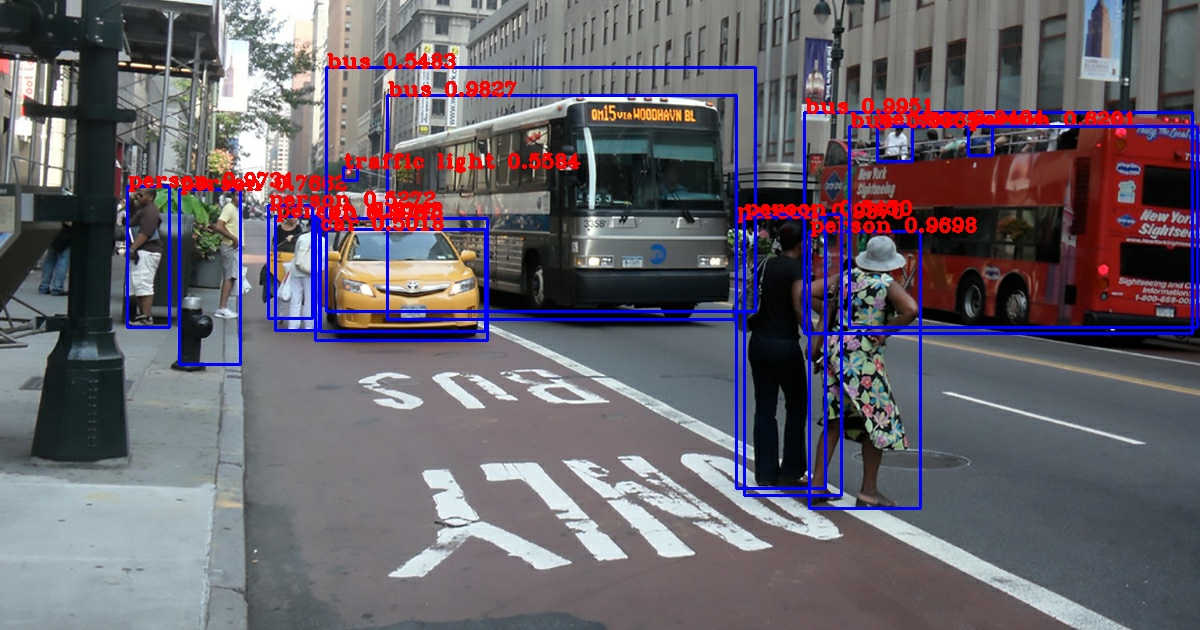

True

In [11]:
apply_pre_trained_detector('data/street.jpg')

## Task 1: Repeat object detector on images from the test_images folder. 
Apply the detector above on all the test images from the test_images folder (3 images)

### Modify FLAGS.image and submit output images in a folder.

I0704 16:17:36.952591 139925651400576 <ipython-input-10-2f4d68bcc5c3>:12] weights loaded
I0704 16:17:36.955858 139925651400576 <ipython-input-10-2f4d68bcc5c3>:15] classes loaded
I0704 16:17:38.048347 139925651400576 <ipython-input-10-2f4d68bcc5c3>:26] time: 0.1060643196105957
I0704 16:17:38.049537 139925651400576 <ipython-input-10-2f4d68bcc5c3>:28] detections:
I0704 16:17:38.057348 139925651400576 <ipython-input-10-2f4d68bcc5c3>:32] 	car, 0.9992826581001282, [0.27649012 0.4105447  0.59023607 0.896624  ]
I0704 16:17:38.062233 139925651400576 <ipython-input-10-2f4d68bcc5c3>:32] 	car, 0.9985067844390869, [0.59527993 0.3980793  0.7218013  0.56224144]
I0704 16:17:38.065527 139925651400576 <ipython-input-10-2f4d68bcc5c3>:32] 	car, 0.996269941329956, [0.7381854  0.44752878 1.0068752  0.9742908 ]
I0704 16:17:38.071021 139925651400576 <ipython-input-10-2f4d68bcc5c3>:32] 	car, 0.9922270774841309, [0.7231026  0.40837514 0.82352275 0.5277095 ]
I0704 16:17:38.074177 139925651400576 <ipython-input-1

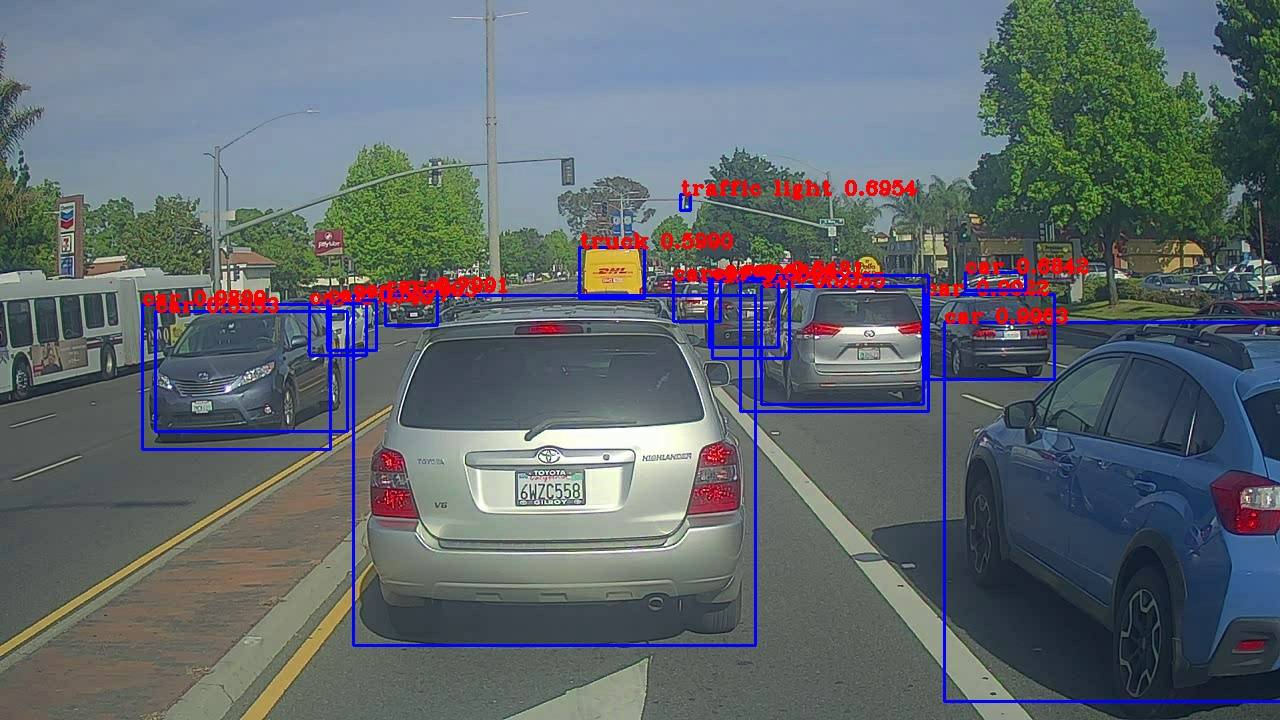

True

In [12]:
apply_pre_trained_detector("data/test_images/test.jpg")

I0704 16:17:45.603028 139925651400576 <ipython-input-10-2f4d68bcc5c3>:12] weights loaded
I0704 16:17:45.606195 139925651400576 <ipython-input-10-2f4d68bcc5c3>:15] classes loaded
I0704 16:17:46.085711 139925651400576 <ipython-input-10-2f4d68bcc5c3>:26] time: 0.09608054161071777
I0704 16:17:46.087030 139925651400576 <ipython-input-10-2f4d68bcc5c3>:28] detections:
I0704 16:17:46.093007 139925651400576 <ipython-input-10-2f4d68bcc5c3>:32] 	giraffe, 0.9978438019752502, [0.30420476 0.09656736 0.87990075 0.869931  ]
I0704 16:17:46.097800 139925651400576 <ipython-input-10-2f4d68bcc5c3>:32] 	zebra, 0.8449259996414185, [0.52784646 0.400668   0.8689227  0.90139806]


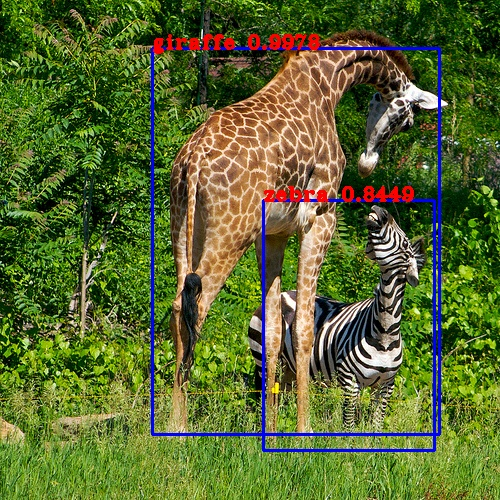

True

In [13]:
apply_pre_trained_detector("data/test_images/giraffe.jpg")

I0704 16:17:55.457779 139925651400576 <ipython-input-10-2f4d68bcc5c3>:12] weights loaded
I0704 16:17:55.463479 139925651400576 <ipython-input-10-2f4d68bcc5c3>:15] classes loaded
I0704 16:17:56.119352 139925651400576 <ipython-input-10-2f4d68bcc5c3>:26] time: 0.0931551456451416
I0704 16:17:56.120552 139925651400576 <ipython-input-10-2f4d68bcc5c3>:28] detections:
I0704 16:17:56.128171 139925651400576 <ipython-input-10-2f4d68bcc5c3>:32] 	car, 0.9945942759513855, [0.08390436 0.4181878  0.17409328 0.47571415]
I0704 16:17:56.132844 139925651400576 <ipython-input-10-2f4d68bcc5c3>:32] 	car, 0.9919449687004089, [0.00217112 0.45459333 0.09452537 0.57086265]
I0704 16:17:56.137154 139925651400576 <ipython-input-10-2f4d68bcc5c3>:32] 	car, 0.9793890118598938, [0.30968887 0.39875886 0.4104424  0.45354083]
I0704 16:17:56.141839 139925651400576 <ipython-input-10-2f4d68bcc5c3>:32] 	car, 0.9760374426841736, [0.4204707  0.38653278 0.50878394 0.4363724 ]
I0704 16:17:56.146325 139925651400576 <ipython-input-

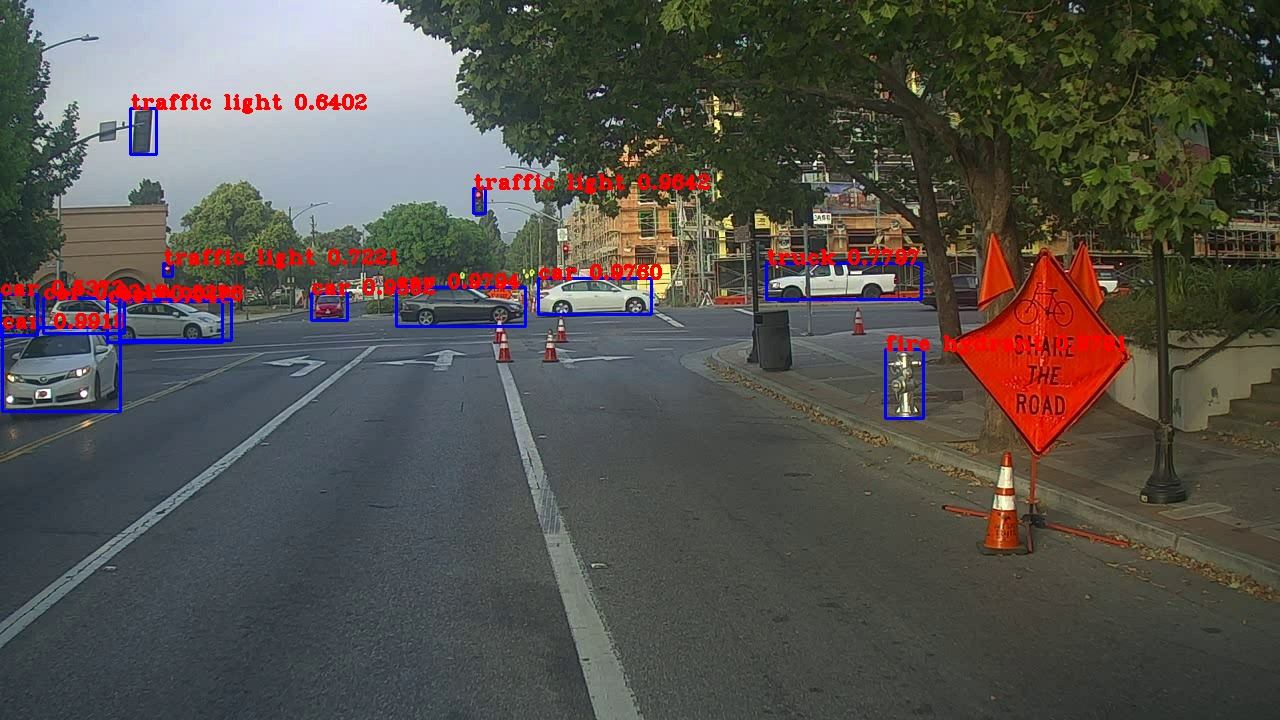

True

In [14]:
apply_pre_trained_detector("data/test_images/0004.jpg")

### 8. Now to retrain/fine tune the detector for additional images
Download the PASCAL VOC 2007 data set. 
Learn about the dataset at https://www.kaggle.com/zaraks/pascal-voc-2007

**(Caution!) This step will take sometime**

### 9. Next, use the voc2012.py file to split the above VOC 2007 data to training and validation

In [15]:
!python tools/voc2012.py \
  --data_dir './data/voc2007_raw/VOCdevkit/VOC2007' \
  --split train \
  --output_file ./data/voc_train.tfrecord

!python tools/voc2012.py \
  --data_dir './data/voc2007_raw/VOCdevkit/VOC2007' \
  --split val \
  --output_file ./data/voc_val.tfrecord

2021-07-04 16:18:10.119536: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
I0704 16:18:11.710634 139868239226752 voc2012.py:92] Class mapping loaded: {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}
I0704 16:18:15.621175 139868239226752 voc2012.py:97] Image list loaded: 2501
100% 2501/2501 [20:01<00:00,  2.08it/s]
I0704 16:38:17.222084 139868239226752 voc2012.py:106] Done
2021-07-04 16:38:18.077450: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
I0704 16:38:19.371619 139970911573888 voc2012.py:92] Class mapping loaded: {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9

### 10. Run the commands below for 5 or more times and report your findings below.

2021-07-04 17:00:07.894590: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Traceback (most recent call last):
  File "tools/visualize_dataset.py", line 7, in <module>
    from yolov3_tf2.models import (
ModuleNotFoundError: No module named 'yolov3_tf2'


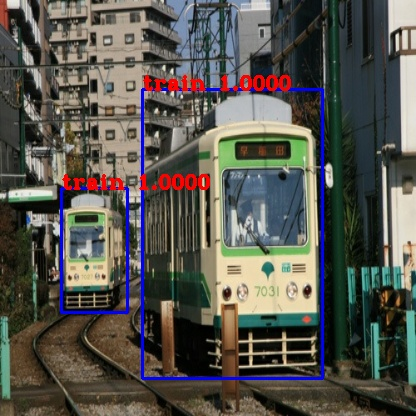

In [19]:
#Run this cell 5 or more times and save the output images.
!python tools/visualize_dataset.py --dataset ./data/voc_train.tfrecord --classes=./data/voc2012.names

from IPython.display import Image
Image(filename='./output.jpg')

### Task 2: 
#### Observations from 5 sample Pascal VOC

Images in the training set are identified correctly.  However, the confidence provided by the algorithm was 100 percent.  With such high confidence, we should interegate the output.

## Task 2: Comment on your observations on object detection for the 5 sample Pascal VOC images from above.

### 10. Next retrain the model using the PASCAL VOC train/validation images below.

**(Caution) This will take sometime!**

In [21]:
!python train.py \
	--dataset ./data/voc_train.tfrecord \
	--val_dataset ./data/voc_val.tfrecord \
	--classes ./data/voc2012.names \
	--num_classes 20 \
	--mode fit --transfer darknet \
	--batch_size 16 \
	--epochs 3 \
	--weights ./checkpoints/yolov3.tf \
	--weights_num_classes 80 

2021-07-04 17:04:11.311428: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-04 17:04:12.603540: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-04 17:04:12.609234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-04 17:04:12.609648: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-07-04 17:04:12.609688: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-04 17:04:12.615502: I tensorflow/stream_executor/platform/default

## Task 3: 
Lets analyze the training process and figure out what is the role of specific functions.
### Pseudocode for training.py 
1. Define Hyperparameters
2. **Define Model**
3. Load training dataset
4. Transform training dataset
5. If validation flag set
  - Load validation dataset
  - Transform validation dataset
6. If transfer learning flag set
 - Apply transfer learning
7. Define optimizer
8. **Define loss function**
9. Compile model
10. Fit model  

### Analyze the functions in 'models.py'. Can you match these functions with the model steps mentioned above?

The code in models.py bulids up the model architecture for the YOLO model instantiated in training.py.  [M]odels.py, also, provide the exact specification of the yolo loss functions used in training.py

### 11. Apply the fine tuned weights on the images from test_images folder.
## Task 4: Collect your outputs on the images from test_images folder.
This can be achieved by modifying FLAGS.image.

In [34]:
def apply_fined_tuned_detector(image_location):
    FLAGS.num_classes = 20
    FLAGS.classes = 'data/voc2012.names'
    FLAGS.weights = 'checkpoints/yolov3_train_3.tf'
    
    filename =  os.path.basename(image_location)
    FLAGS.image = image_location # 'data/street.jpg'

    # Lower threshold due to insufficient training
    FLAGS.yolo_iou_threshold = 0.2
    FLAGS.yolo_score_threshold = 0.2

    if FLAGS.tiny:
        yolo = YoloV3Tiny(classes=FLAGS.num_classes)
    else:
        yolo = YoloV3(classes=FLAGS.num_classes)

    yolo.load_weights(FLAGS.weights).expect_partial()
    logging.info('weights loaded')

    class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
    logging.info('classes loaded')

    img_raw = tf.image.decode_image(
        open(FLAGS.image, 'rb').read(), channels=3)

    img = tf.expand_dims(img_raw, 0)
    img = transform_images(img, FLAGS.size)

    t1 = time.time()
    boxes, scores, classes, nums = yolo(img)
    t2 = time.time()
    logging.info('time: {}'.format(t2 - t1))

    logging.info('detections:')
    for i in range(nums[0]):
        logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                            np.array(scores[0][i]),
                                            np.array(boxes[0][i])))

    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

    from IPython.display import Image, display
    display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))
    #st = cv2.imwrite(f"data/Training/raining/{filename}", img)
    st = cv2.imwrite(f"data/Training/{filename}", img)
    #st = True
    return st

In [ ]:
#st = cv2.imwrite(f"data/No_training/{filename}", img)

I0704 17:47:00.859926 139925651400576 <ipython-input-25-66ad2673b1e3>:16] weights loaded
I0704 17:47:00.864712 139925651400576 <ipython-input-25-66ad2673b1e3>:19] classes loaded
I0704 17:47:01.003468 139925651400576 <ipython-input-25-66ad2673b1e3>:30] time: 0.09537959098815918
I0704 17:47:01.008650 139925651400576 <ipython-input-25-66ad2673b1e3>:32] detections:
I0704 17:47:01.013914 139925651400576 <ipython-input-25-66ad2673b1e3>:36] 	person, 0.407998263835907, [0.6605265  0.40745872 0.7596921  0.7022534 ]
I0704 17:47:01.018318 139925651400576 <ipython-input-25-66ad2673b1e3>:36] 	person, 0.2098209410905838, [0.659492  0.4329933 0.7622374 0.7528453]


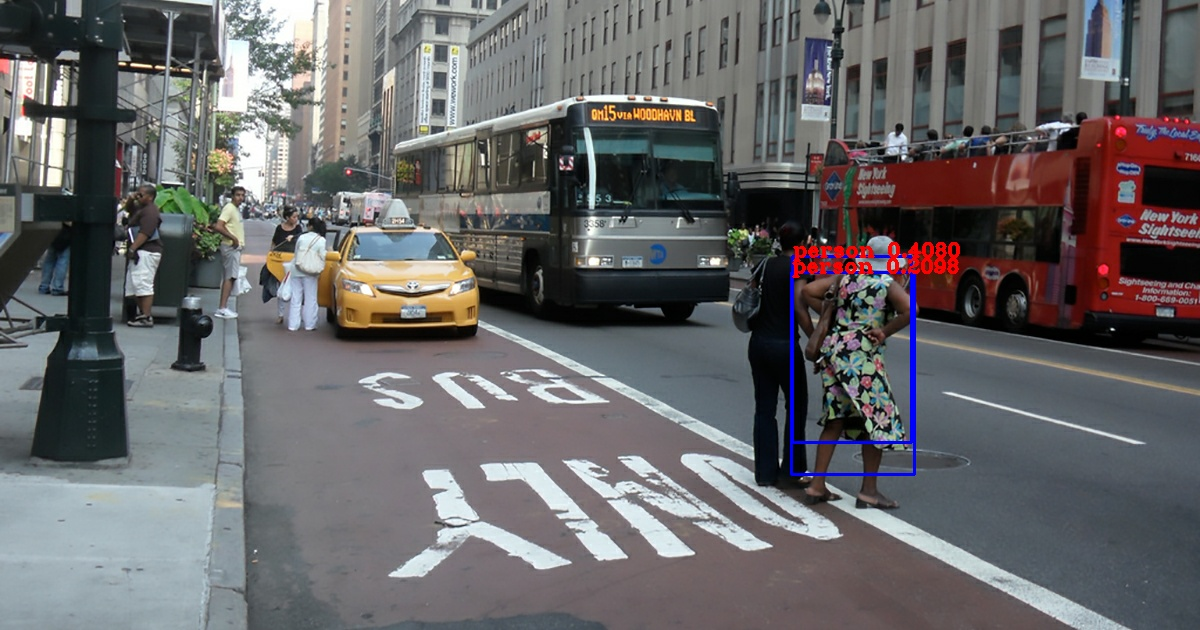

In [25]:
FLAGS.num_classes = 20
FLAGS.classes = 'data/voc2012.names'
FLAGS.weights = 'checkpoints/yolov3_train_3.tf'
FLAGS.image = 'data/street.jpg'

# Lower threshold due to insufficient training
FLAGS.yolo_iou_threshold = 0.2
FLAGS.yolo_score_threshold = 0.2

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

I0704 17:56:04.349952 139925651400576 <ipython-input-27-d77aa455d25a>:19] weights loaded
I0704 17:56:04.354770 139925651400576 <ipython-input-27-d77aa455d25a>:22] classes loaded
I0704 17:56:04.482687 139925651400576 <ipython-input-27-d77aa455d25a>:33] time: 0.09450292587280273
I0704 17:56:04.483864 139925651400576 <ipython-input-27-d77aa455d25a>:35] detections:
I0704 17:56:04.491476 139925651400576 <ipython-input-27-d77aa455d25a>:39] 	person, 0.407998263835907, [0.6605265  0.40745872 0.7596921  0.7022534 ]
I0704 17:56:04.496373 139925651400576 <ipython-input-27-d77aa455d25a>:39] 	person, 0.2098209410905838, [0.659492  0.4329933 0.7622374 0.7528453]


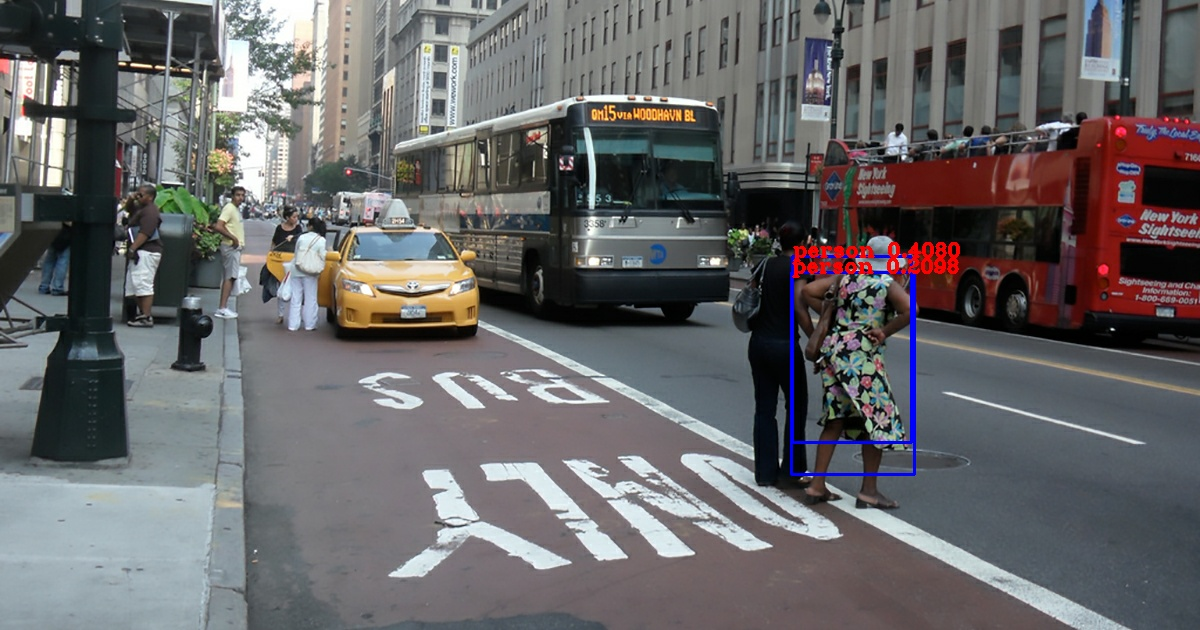

True

In [28]:
apply_fined_tuned_detector("data/street.jpg")

I0704 18:03:31.377455 139925651400576 <ipython-input-34-771751966938>:19] weights loaded
I0704 18:03:31.380966 139925651400576 <ipython-input-34-771751966938>:22] classes loaded
I0704 18:03:31.505119 139925651400576 <ipython-input-34-771751966938>:33] time: 0.10269021987915039
I0704 18:03:31.506396 139925651400576 <ipython-input-34-771751966938>:35] detections:


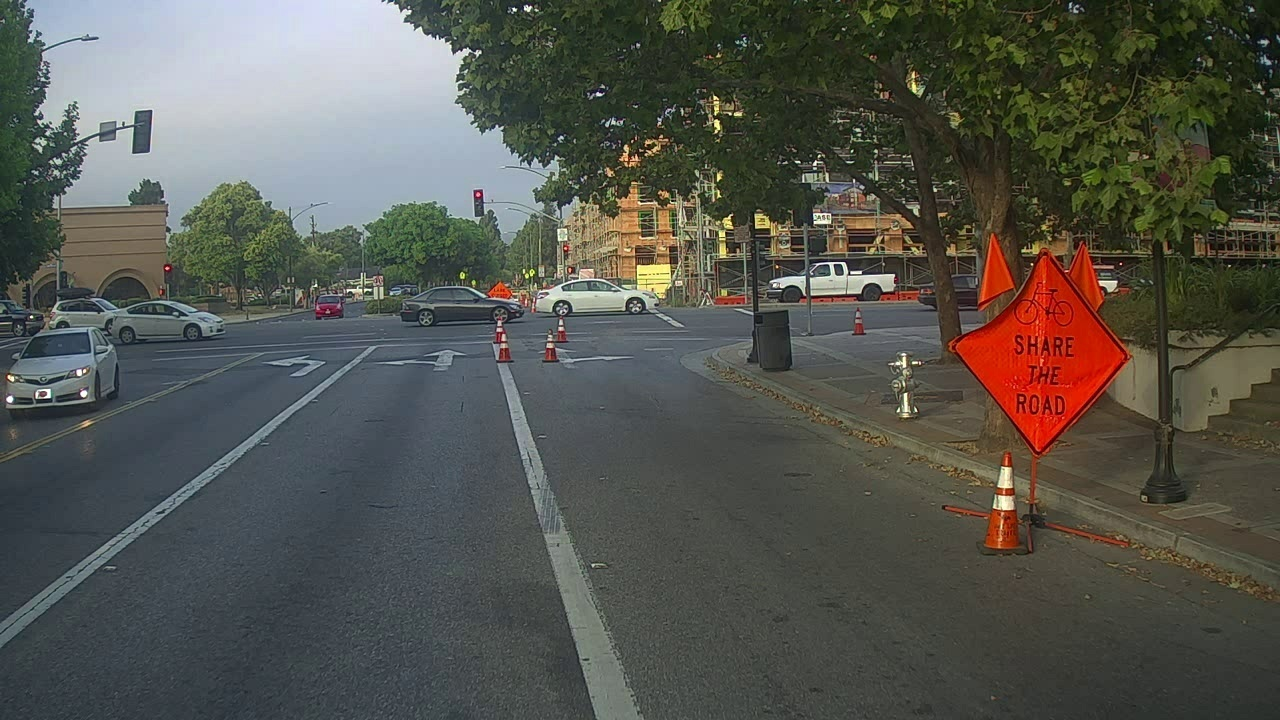

True

In [37]:
#apply_fined_tuned_detector("data/test_images/test.jpg")
#apply_fined_tuned_detector("data/test_images/giraffe.jpg")
apply_fined_tuned_detector("data/test_images/0004.jpg")

## We notice that since fine tuning had lesser class categories, we now observe fewer bounding boxes. This is the fine-tuning process.

## Final Submission for this assignment includes a folder with following structure
``` Results
      |_______No training
                  |____004.jpg
                  |_____giraffe.jpg
                  |_____test.jpg
      |_______Training
                  |____004.jpg
                  |_____giraffe.jpg
                  |_____test.jpg
                  
```

## Here folder 'No training' contains images with the bounding boxes before fine tuning and 'Training' contains images with the bounding boxes after fine tuning.